# Geospatial Data Analysis I 

## Spatial Interploation - Solution

### Part 1: Deterministic Interpolation

There are several Python Packages that contain useful libraries and functions for spatial interpolation, e.g.: 

- scipy.interpolate: Univariate & multivariate interpolation, functions for linear, spline, Nearest Neighbour und radial basis function interpolation

- scipy.spatial: Delauney Tesselation, Voronoi Diagrams und several plotting functions

- Inverse distance weighting: e.g. via PyGeM (https://mathlab.github.io/PyGeM/index.html), or other packages (https://github.com/paulbrodersen/inverse_distance_weighting)

In this exercise we are going to take a closer look at the options in `scipy`. As data we are going to use measured groundwater heads and temperatures in Karlsruhe (Menberg et al., 2013). 

#### Exercise 1: scipy.spatial and scipy.interpolate.griddata

For interpolating any data we first need to specifiy a regular grid specifying the points on which to interpolate.  

- First, read to the data from "interp_data.csv" as a Pandas DataFrame.  

- For defining the interpolation grid, start with extracting the minimum (`data.min`) and maximum (`data.max`) values of the columns with the x and y coordinates. In order to create a small buffer around the extreme points add / substract a small value (e.g. 1000m) from the min and max values. 

- Then, combine these variables to a list that specfies the overall extent of the grid: `extent = x_min, x_max, y_min, y_max` 

- Last, create one array for x and y coordinates each using the function `x, y = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep]`. Finally, plot the created coordinates as a 2D grid (`plt.scatter()`) to visualise the interpolation grid.

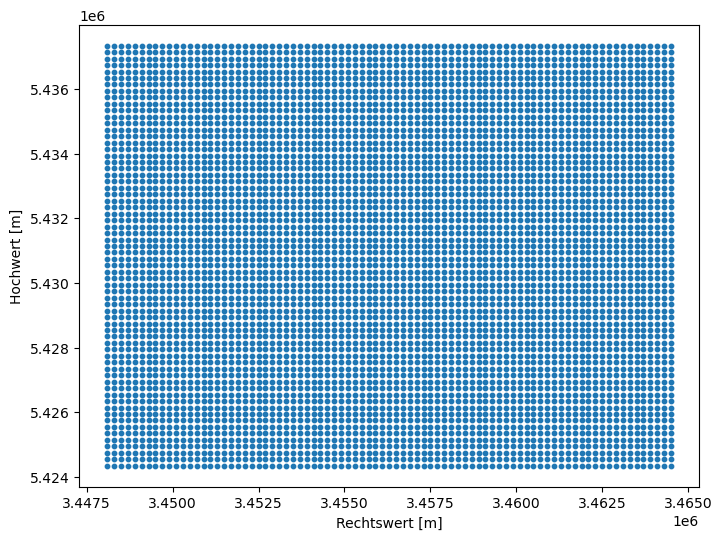

In [2]:
# [1]
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read data from csv / Excel
data = pd.read_csv('interp_data.csv', sep=';', encoding='cp1252')

# defining the extent of the interpolation grid, including a small buffer
extent = x_min, x_max, y_min, y_max = [data.Rechtswert.min()-1000, data.Rechtswert.max()+1000,
                                       data.Hochwert.min()-1000, data.Hochwert.max()+1000]

# creating the grid
grid_x, grid_y = np.mgrid[x_min:x_max:200, y_min:y_max:200]

# plotting
plt.figure(2, figsize=(8,6))
plt.scatter(grid_x, grid_y, s=10)
plt.xlabel('Rechtswert [m]')
plt.ylabel('Hochwert [m]')
plt.show()

Now, we can interpolate the groundwater temperature data on the created grid using *scipy* and `scipy.interpolate.griddata()`. This function supports different methods (Nearest Neighbour, linear interpolation, cubic spline interpolation, etc.), which we want to compara against each other. 

- First, we need to create tuples from the orginal x and y coordinates, i.e. combine them into a single entry of an entry indicated by a double bracket (`index [[x, y]]`). To extract the numeric values from the DataFrame you can use `data.values`, or combined to `data[[value1, value2]].values`. 

- Next, create the interpolated data sets using `scipy.interpolate.griddata()`, and as arguments the created tuples, the values of the measured groundwater temperatures (`data.values`), the x and y coordinates of the grid as a list (`(x, y)`), and the interpolation method to use (`method=...`). Create three data sets using "nearest", "linear" and " cubic" as inputs for the method argument. 

- Finally, visualise the three interpolation results in a figure with three subplots. You can visualise the interpolated raster data using `matplotlib.pyplot.imshow()` with the interpolated data (transposed as `data.T`), the starting point (`origin='lower'`) and the extent of the data (`extent=area`) as input arguments. As area you can use the defined boundaries of the grid from above. 

- Compare the plotted results. Which method seems to produce the most reasonable results? 

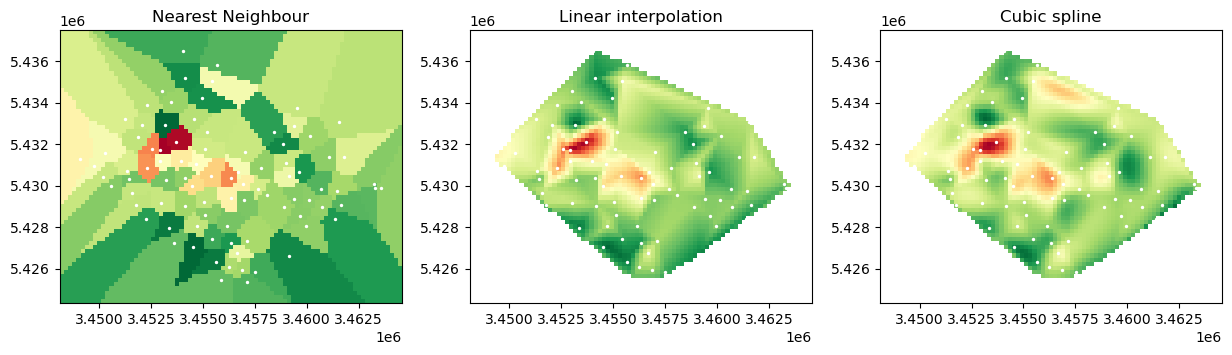

In [3]:
# [2]
# importing packages
from scipy.interpolate import griddata

# transforming original coordinate data into tuples
points = data[['Rechtswert', 'Hochwert']].values

# creating three interpolated data sets using different interpolation algorithms
grid_z0 = griddata(points, data.GWT.values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, data.GWT.values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, data.GWT.values, (grid_x, grid_y), method='cubic')

# Plotting the three different results 
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
ax.imshow(grid_z0.T, origin='lower', extent=extent, cmap='RdYlGn_r')
ax.scatter(data.Rechtswert, data.Hochwert, s=2, c='w')
ax.set_title('Nearest Neighbour')

ax = axs[1]
ax.imshow(grid_z1.T, origin='lower', extent=extent, cmap='RdYlGn_r')
ax.scatter(data.Rechtswert, data.Hochwert, s=2, c='w')
ax.set_title('Linear interpolation')

ax = axs[2]
ax.imshow(grid_z2.T, origin='lower', extent=extent, cmap='RdYlGn_r')
ax.scatter(data.Rechtswert, data.Hochwert, s=2, c='w')
ax.set_title('Cubic spline')

plt.show()

#### Exercise 2: scipy.interpolate.rbf

Besides the options from above, *Scipy* also contains different functions for interpolation with radial basis functions (RBFs). The default option in `scipy.interpolate.Rbf()` is a multi-quadratic function that exactly represents the values at the measurement locations (*exact interpolation*). 

- First, define an *interpolation object* using `scipy.interpolate.Rbf()` using the x and y coordinates of the measured data, as well as the measured values as input arguments. 

- Apply this interpolation object to the x and y coordinates of the created grid (`object(x-grid, y-grid)`), and visualise the resulting interpolated data using `matplotlib.pyplot.imshow()`. 

- In order to compare the interpolated data to the measured values, also plot the measured data using `matplotlib.pyplot.scatter()` setting the groundwater temperature values as color (`c=data.GWTvalues`). 

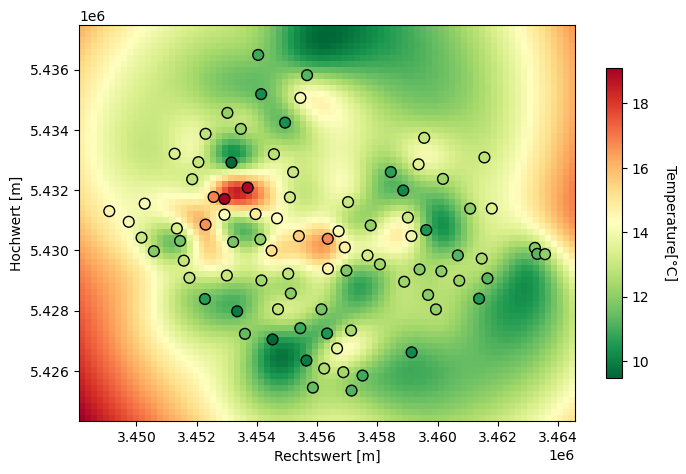

In [4]:
# [3]
# importing packages
from scipy.interpolate import Rbf

# creating interpolation object
rbfi = Rbf(data.Rechtswert, data.Hochwert, data.GWT)

# applying interpolation object 
di = rbfi(grid_x, grid_y)

# plotting 
plt.figure(3, figsize=(8,6))
ax = fig.add_subplot(1,1,1)

c1 = plt.imshow(di.T, origin="lower", extent=extent, cmap = 'RdYlGn_r')
c2 = plt.scatter(data.Rechtswert, data.Hochwert, s=60, c=data.GWT, edgecolor='k',  cmap = 'RdYlGn_r')

cbar = plt.colorbar(c1, shrink=0.67)
cbar.set_label(label="Temperature[°C]", rotation=270, labelpad=20)
plt.xlabel('Rechtswert [m]')
plt.ylabel('Hochwert [m]')
plt.show()


### Part 2: Stochastic interpolation - Kriging

There are several packages that offer options for interpolation with Kriging:  
 
 - SciKit GStat: several options to analyse variograms, but interpolation only for Ordinary Kriging (i.e. data without trend or drift): https://scikit-gstat.readthedocs.io/en/latest/install.html#conda-forge
 
 - PyKrige: contains implementations for Ordinary and Universal Kriging (data with trend or drift), but less sophisticated options for detailed analysis of variograms https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/index.html

 
In this exercise we are going to use SciKit GStat. Download and install the package in your virtual environment using the command `pip install scikit-gstat` in the terminal. 

Kriging interpolation always starts with a variogram analysis. 

- First, create a *variogram object* using `skgstat.Variogram()`. As input arguments the functions requires the coordinates of the measured data as tuples (just as in #2), as well as the measured groundwater temperature values.  

- Then, you can visualise the variogram using `VariogramObjekt.plot();` (the ';' is important!). Depending on your laptop this can take a few seconds...

c:\Users\kathr\anaconda3\envs\GDA1\Lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


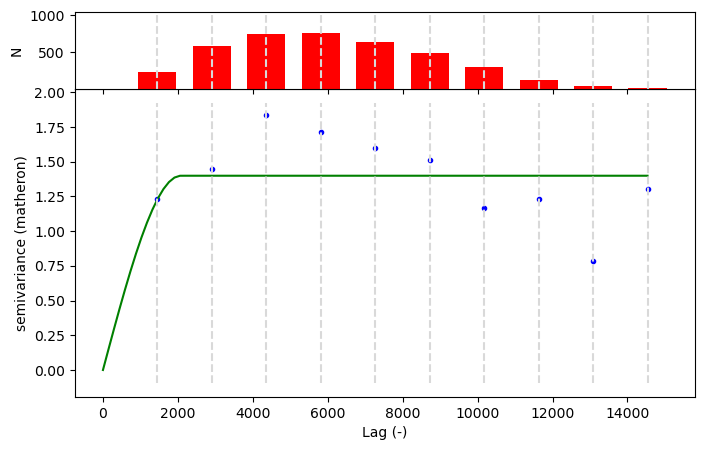

In [5]:
# [4]
# importing packages
from skgstat import Variogram

# creating variogram object
Var = Variogram(data[['Rechtswert', 'Hochwert']].values, data.GWT)

# plotting variogram
Var.plot();

As one can see in the semivariogram plot, the values beyond a lag of 8000 meters is not well supported by data (dropping bar heights in the top row). The variogram analysis should thus be adapted to account for this. 

- Change the maximum lag of the variogram analysis by adding `.maxlag = 8000` to your variogram object. 

- Also, as we have more than 90 measurements we can increase the number of lag classes to 15 by adding `.n_lags=15` to the variogram object. 

- Finally, plot the variogram again as above. 

c:\Users\kathr\anaconda3\envs\GDA1\Lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


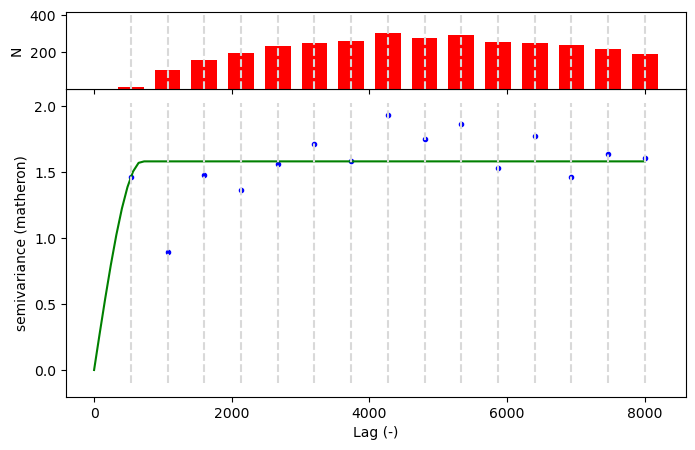

In [6]:
# [5]
# maxlag und nlag des Variogrammobjekts anpassen
Var.maxlag = 8000
Var.n_lags = 15

# Variogrammobjekt plotten
Var.plot();

While the fit of the line looks good for higher lags, this is not the case for short distances (i.e. a lag smaller than 4000). This range however is very important for determining the weights for kriging interpolation. If not defined otherwise `skgstat.Variogram()` by default uses a spherical variance model. 

- In addition to the variogram object above created above (i.e. the one aith a spherical model), create two more with other models. To do so, you can specify the model by `VariogramObject.model = 'spherical'`, or "exponential" and "gaussian".  

- The variogram object also has a functionality to calculate the goodness fit as the root mean square error (RMSE). Use `VariogramObject.rmse` to evaluatethe goodness of fit of all three models. Which one shows the best fit? Also, compare the visual goodness of fit to the RMSE values. 

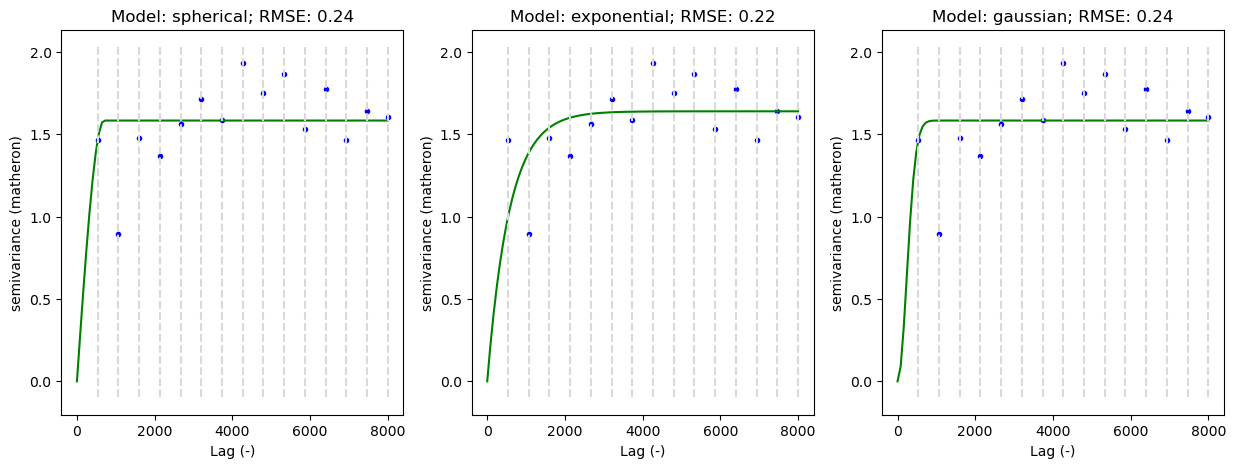

In [7]:
# [6]
# importing packages
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
Var.model = 'spherical'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('spherical', Var.rmse))

ax = axs[1]
Var.model = 'exponential'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('exponential', Var.rmse))

ax = axs[2]
Var.model = 'gaussian'
Var.plot(axes=ax, hist=False, show=False)
ax.set_title('Model: %s; RMSE: %.2f' % ('gaussian', Var.rmse))
plt.show()

Pick the variogram model that fits best and perform Ordinary Kriging using `skgstat.OrdinaryKriging()`. 

- First, define an interpolation object using `OrdinaryKriging()`. Required input arguments are the Variogram object (with the best fitting model), as well as the minimum and maximum number of ssurrunding measurement points to be used for interpolation. These numbers depend on the number of measurements and are often determined iteratively. Here, set `min_points=2` and `max_points=8`.  

- Define a regular grid of interpolation points, as in Part 1.  

- Apply the `.transform()` fucntion to the interpolation object. This requires the x and y coordinates as individual 1D Numpy arrays. You can create those arrays by `array.flatten()`. 

- Visualise the interpolation results with `plt.imshow()` . To do so, you have to reshape the 1D array with the interpolated data into a 2D matrix, e.g. with `array.reshape(dimensions)`. You can pick the dimensions from the original grid by `grid.shape`. 

- Also, plot the loaction of the measurements (e.g. as black circles) on top of the interpolated raster. 

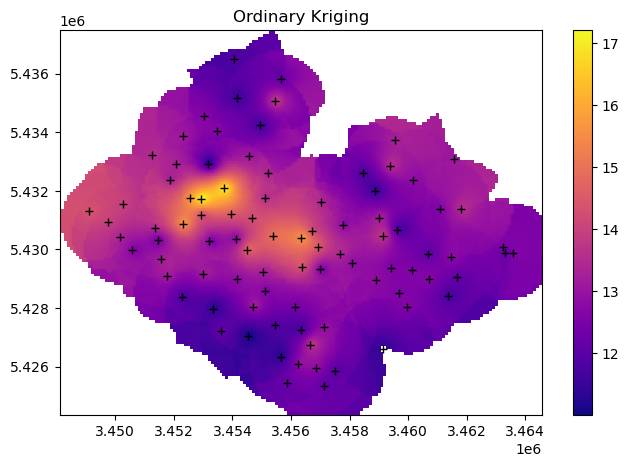

In [8]:
# [7]
# importing pacakages
from skgstat import OrdinaryKriging
import numpy as np

# setting the best fitting variogram model from above 
Var.model = 'exponential'

# creating the interpolation object 
ok = OrdinaryKriging(Var, min_points=2, max_points=8)

# creating a grid for the interpolation (same as for Part 1)
extent = x_min, x_max, y_min, y_max = [data.Rechtswert.min()-1000, data.Rechtswert.max()+1000,
                                       data.Hochwert.min()-1000, data.Hochwert.max()+1000]
grid_x, grid_y = np.mgrid[x_min:x_max:100, y_min:y_max:100]

# creating 1D Arrays based on the grid and transforming them
field = ok.transform(grid_x.flatten(), grid_y.flatten())

# reshaping the created variable back to 2D for plotting  
field = field.reshape(grid_x.shape)

# plotting the interpolation and data
plt.figure(figsize=(8, 5))
plt.imshow(field.T, origin='lower', extent=extent, cmap='plasma')
plt.title('Ordinary Kriging')
plt.plot(data.Rechtswert, data.Hochwert, '+k')
plt.colorbar()
plt.show()

## END

### References

Menberg et al. (2013): Long-term evolution of anthropogenic heat fluxes into a subsurface urban heat island, Environ. Sci. Technol. 47(17) (2013) 9747-9755

https://colab.research.google.com/github/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb

https://mmaelicke.github.io/scikit-gstat/tutorials/01_getting_started.html